# Barrier Options and Digital Option Payoff Valuation

## 1. Introduction to Barrier Options

Barrier options are a type of exotic options where the payoff depends on whether the underlying asset reaches a specified barrier level during the option’s lifetime. These options can be categorized as follows:

- **Knock-in Options**: Become active only if the underlying asset reaches a certain price level.
  - **Up-and-in**: Activated when the asset price goes above the barrier.
  - **Down-and-in**: Activated when the asset price goes below the barrier.

- **Knock-out Options**: Cease to exist if the underlying asset reaches a specified barrier level.
  - **Up-and-out**: Expires worthless if the asset price goes above the barrier.
  - **Down-and-out**: Expires worthless if the asset price goes below the barrier.

These options are often used in structured financial products and risk management strategies.

---

## 2. Monte Carlo Simulation for Digital and Barrier Options

To price a barrier option, we use Monte Carlo simulations with the **Geometric Brownian Motion (GBM)** model:

\[
dS_t = rS_t dt + \sigma S_t dW_t
\]

where:
- \( S_t \) is the underlying asset price,
- \( r \) is the risk-free rate,
- \( \sigma \) is the volatility,
- \( dW_t \) represents a Wiener process (random motion).

We simulate multiple paths for the underlying asset and check if they breach the barrier level.

---

## 3. Digital Payoff Valuation Formula

The `digtalpayoffValuation` function is used to compute the present value of a digital option:

\[
V_0 = e^{-rT} \mathbb{E} [\text{Payoff}(S_T)]
\]

where:
- \( V_0 \) is the present value of the option.
- \( r \) is the risk-free interest rate.
- \( T \) is the time to maturity.
- \( S_T \) is the asset price at expiration.
- \( \text{Payoff}(S_T) \) depends on whether it is a call or put option.

For a digital **call option**, the payoff function is:

\[
\text{Payoff} = \mathbb{1} (S_T > K)
\]

For a digital **put option**, the payoff function is:

\[
\text{Payoff} = \mathbb{1} (S_T < K)
\]

where \( \mathbb{1} \) is an indicator function that returns 1 if the condition is met, otherwise 0.

---

## 4. Barrier Option Valuation

The function `UpandOutBarrier` prices an **up-and-out barrier call option** using Monte Carlo simulation. The key steps are:

1. Generate multiple asset price paths using the **Geometric Brownian Motion** model.
2. Check if any path breaches the barrier level \( S_u \).
3. If the barrier is **not breached**, compute the payoff; otherwise, the option is worthless.
4. Discount the expected payoff back to present value:

\[
V_0 = e^{-rT} \mathbb{E} [\text{Payoff}(S_T) \cdot \mathbb{1} (S_t < S_u \text{ for all } t)]
\]

where \( \mathbb{1} \) ensures that the barrier has **not** been breached.

---

## 5. Visualization and Interpretation

- **Simulated Price Paths**: Shows how the asset price evolves over time and whether it hits the barrier.
- **Payoff Function**: Illustrates how digital call and put payoffs behave.
- **Histogram of Final Asset Prices**: Provides insight into the distribution of simulated prices at expiration.
- **Comparison of Digital and Barrier Option Prices**: Highlights the difference between standard digital options and barrier options.

---

## 6. Applications in Quantitative Finance

Barrier options are commonly used in:
- **Risk Management**: Investors use knock-out options to limit downside risks.
- **Exotic Derivatives Trading**: Hedge funds and investment banks trade barrier options to enhance yield.
- **Corporate Finance**: Used in structured products with customized payoff structures.

### Practical Example:
A trader expects stock XYZ to rise but wants a cheaper option contract. They buy an **up-and-out call option** with a barrier of $150. If XYZ reaches $150 before expiration, the option expires worthless. If not, they receive the call option’s payoff.

---

## 7. Conclusion

Barrier options offer unique risk-reward characteristics and are widely used in financial engineering. The Monte Carlo approach provides a flexible way to estimate their fair value under stochastic market conditions.

---


Value of the contract at t0 =28.96281256609822
Value of the barrier contract at t0 =2.708652503283139
Value of the digital contract at t0 = 28.9628
Value of the barrier contract at t0 = 2.7087


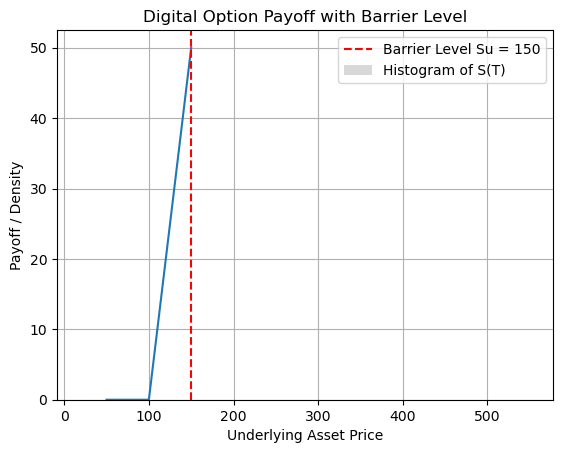

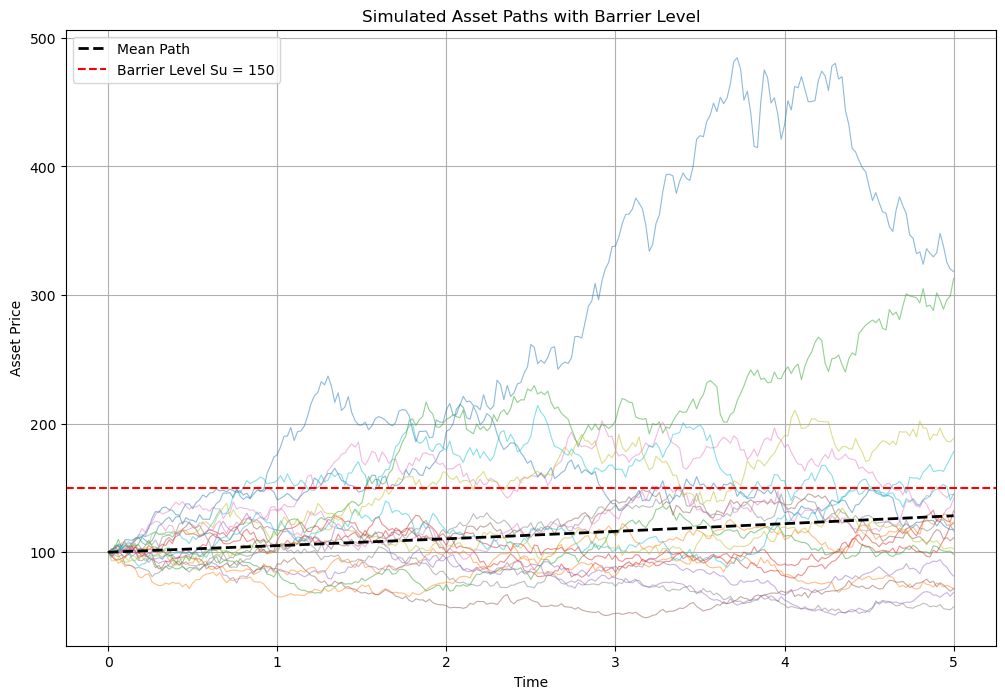

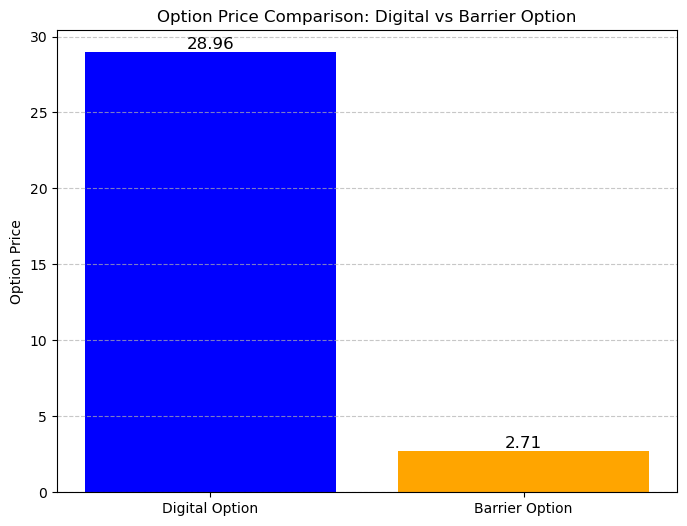

Value of the contract at t0 =29.443087680654514
Value of the barrier contract at t0 =2.693738261043945
Value of the digital contract at t0 = 29.4431
Value of the barrier contract at t0 = 2.6937


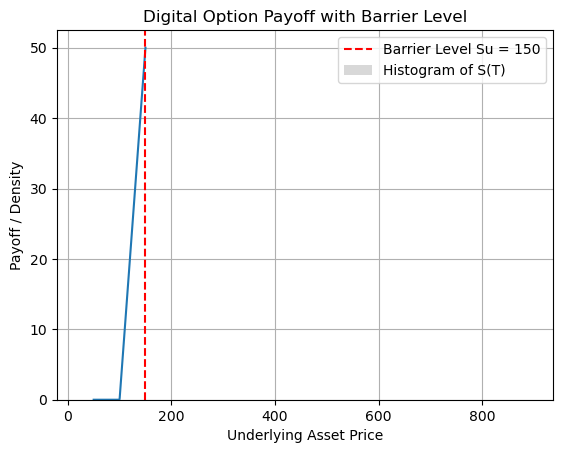

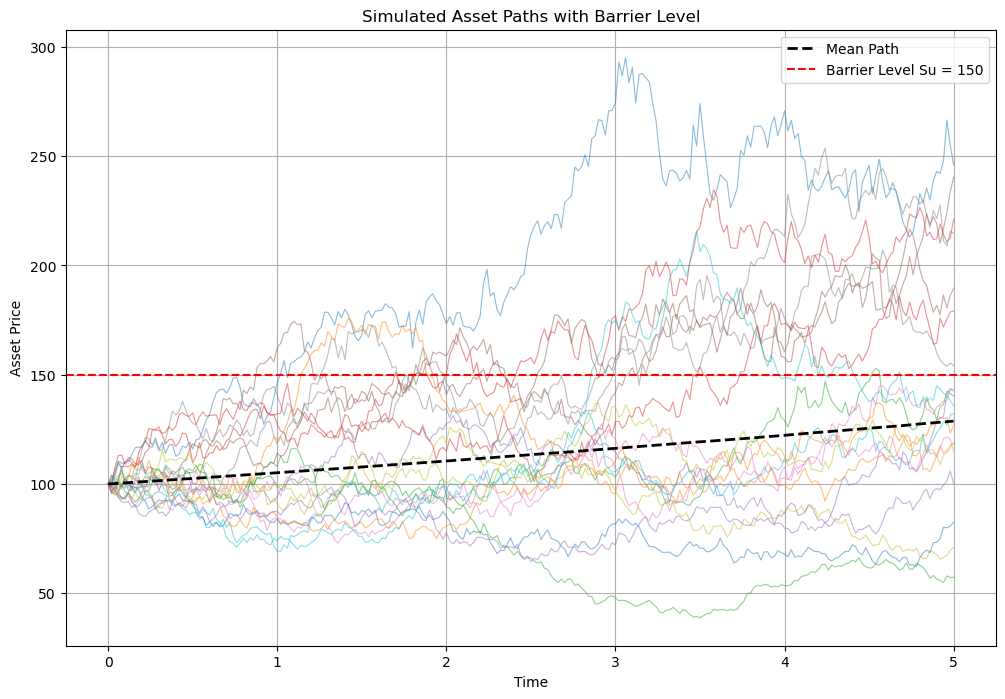

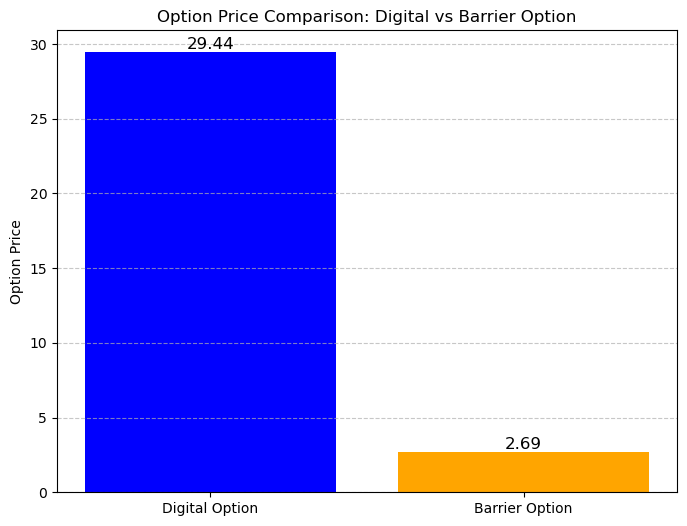

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import enum


class OptionType(enum.Enum):
    call = 1.0
    put = -1.0


def digtalpayoffValuation(S, T, r, payoffcall, payoffput, cp):
    if cp == OptionType.call:
        return np.exp(-r * T) * np.mean(payoffcall(S))
    elif cp == OptionType.put:
        return np.exp(-r * T) * np.mean(payoffput(S))
    else:
        raise ValueError("Invalid OptionType provided")
    # monte carlo


def GeneratePathsGBMEuler(NoOfPaths, NoOfSteps, T, r, sigma, S_0):
    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps + 1])

    # Euler Approximation
    S1 = np.zeros([NoOfPaths, NoOfSteps + 1])
    S1[:, 0] = S_0

    time = np.zeros([NoOfSteps + 1])

    dt = T / float(NoOfSteps)
    for i in range(0, NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        W[:, i + 1] = W[:, i] + np.power(dt, 0.5) * Z[:, i]

        S1[:, i + 1] = S1[:, i] + r * S1[:, i] * dt + sigma * S1[:, i] * (W[:, i + 1] - W[:, i])
        time[i + 1] = time[i] + dt

    # Retun S1 and S2
    paths = {"time": time, "S": S1}
    return paths


def UpandOutBarrier(S, T, r, payoffcall, payoffput, cp, su):
    # handling barrer
    n1, n2 = S.shape
    barrier = np.zeros([n1, n2]) + su
    if cp == OptionType.call:
        hitM = S > barrier
        hitVec = np.sum(hitM, axis=1)
        hitVec = (hitVec == 0.0).astype(int)
        V_0 = np.exp(-r * T) * np.mean(payoffcall(S[:, -1] * hitVec))
    elif cp == OptionType.call:
        hitM = S < barrier
        hitVec = np.sum(hitM, axis=1)
        hitVec = (hitVec == 0.0).astype(int)
        V_0 = np.exp(-r * T) * np.mean(payoffcall(S[:, -1] * hitVec))
    else:
        raise ValueError("Invalid OptionType provided")
    return V_0


def mainCalculation():
    NoOfPaths = 10000
    NoOfSteps = 250
    cp = OptionType.call
    S0 = 100.0
    r = 0.05
    T = 5
    sigma = 0.2
    Su = 150
    paths = GeneratePathsGBMEuler(NoOfPaths, NoOfSteps, T, r, sigma, S0)
    S_paths = paths["S"]
    S_T = S_paths[:, -1]
    time = paths["time"]
    # payoff setting
    K = 100

    payoffcall = lambda S: np.maximum(S - K, 0.0)  # - np.maximum(S-K2,0)
    payoffput = lambda S: np.maximum(K - S, 0.0)
    S_T_grid = np.linspace(50, S0 * 1.5, 200)
    if cp == OptionType.call:
        plt.plot(S_T_grid, payoffcall(S_T_grid))
    elif cp == OptionType.put:
        plt.plot(S_T_grid, payoffput(S_T_grid))
    else:
        raise ValueError("Invalid OptionType provided")
    val_to = digtalpayoffValuation(S_T, T, r, payoffcall, payoffput, cp)
    print("Value of the contract at t0 ={0}".format(val_to))
    barrier_price = UpandOutBarrier(S_paths, T, r, payoffcall, payoffput, cp, Su)
    print("Value of the barrier contract at t0 ={0}".format(barrier_price))

    # Mark the barrier level on the payoff plot as a vertical line
    plt.axvline(x=Su, color='red', linestyle='--', label=f'Barrier Level Su = {Su}')
    # Overlay a histogram of terminal asset prices
    plt.hist(S_T, bins=50, density=True, alpha=0.3, color='gray', label="Histogram of S(T)")
    plt.title("Digital Option Payoff with Barrier Level")
    plt.xlabel("Underlying Asset Price")
    plt.ylabel("Payoff / Density")
    plt.legend()
    plt.grid(True)

    # Calculate digital option price (without barrier) and barrier option price
    digital_price = digtalpayoffValuation(S_T, T, r, payoffcall, payoffput, cp)
    barrier_price = UpandOutBarrier(S_paths, T, r, payoffcall, payoffput, cp, Su)
    print("Value of the digital contract at t0 = {:.4f}".format(digital_price))
    print("Value of the barrier contract at t0 = {:.4f}".format(barrier_price))

    # Plot simulated asset paths with the barrier level
    plt.figure(figsize=(12, 8))
    for i in range(min(20, NoOfPaths)):  # Plot 20 sample paths for clarity
        plt.plot(time, S_paths[i, :], lw=0.8, alpha=0.5)
    plt.plot(time, np.mean(S_paths, axis=0), 'k--', lw=2, label="Mean Path")
    plt.axhline(y=Su, color='red', linestyle='--', label=f'Barrier Level Su = {Su}')
    plt.title("Simulated Asset Paths with Barrier Level")
    plt.xlabel("Time")
    plt.ylabel("Asset Price")
    plt.legend()
    plt.grid(True)

    # Bar plot comparing the digital option price and barrier option price
    plt.figure(figsize=(8, 6))
    labels = ['Digital Option', 'Barrier Option']
    prices = [digital_price, barrier_price]
    bar_colors = ['blue', 'orange']
    bars = plt.bar(labels, prices, color=bar_colors)
    plt.title("Option Price Comparison: Digital vs Barrier Option")
    plt.ylabel("Option Price")
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()


if __name__ == "__main__":
    mainCalculation()

mainCalculation()